# Import dependency

In [0]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen

# data process
In the next cell, we specify the URLs of two images we would like to process with DELF in order to match and compare them.

In [0]:
IMAGE_1_URL = 'https://upload.wikimedia.org/wikipedia/commons/c/ce/2006_01_21_Ath%C3%A8nes_Parth%C3%A9non.JPG'
IMAGE_2_URL = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/ACROPOLIS_1969_-_panoramio_-_jean_melis.jpg'


Download, resize, save and display the images.

In [0]:

# The names that will be used for the resized local images.

IMAGE_1_JPG = 'image_1.jpg'
IMAGE_2_JPG = 'image_2.jpg'

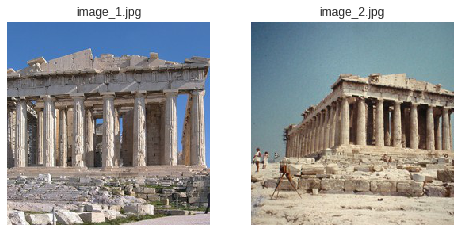

In [4]:
def download_and_resize_image(url, filename, new_width=256, new_height=256):
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert('RGB')
  pil_image_rgb.save(filename, format='JPEG', quality=90)

download_and_resize_image(IMAGE_1_URL, IMAGE_1_JPG)
download_and_resize_image(IMAGE_2_URL, IMAGE_2_JPG)

def show_images(image_path_list):
  plt.figure()
  for i, image_path in enumerate(image_path_list):
    plt.subplot(1, len(image_path_list), i+1)
    plt.imshow(np.asarray(Image.open(image_path)))
    plt.title(image_path)
    plt.grid(False)
    plt.yticks([])
    plt.xticks([])
  plt.show()

show_images([IMAGE_1_JPG, IMAGE_2_JPG])


Next, we define a function to read the images into a tensor so that they can be processed by TensorFlow.

In [0]:
def image_input_fn():
  filename_queue = tf.train.string_input_producer(
      [IMAGE_1_JPG, IMAGE_2_JPG], shuffle=False)
  reader = tf.WholeFileReader()
  _, value = reader.read(filename_queue)
  image_tf = tf.image.decode_jpeg(value, channels=3)
  return tf.image.convert_image_dtype(image_tf, tf.float32)


# Apply the DELF module to the data
The DELF module takes an image as input and will describe noteworthy points with vectors. The following cell contains the core of this colab's logic.

In [6]:

tf.reset_default_graph()
tf.logging.set_verbosity(tf.logging.FATAL)

m = hub.Module('https://tfhub.dev/google/delf/1')

# The module operates on a single image at a time, so define a placeholder to
# feed an arbitrary image in.
image_placeholder = tf.placeholder(
    tf.float32, shape=(None, None, 3), name='input_image')

module_inputs = {
    'image': image_placeholder,
    'score_threshold': 100.0,
    'image_scales': [0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0],
    'max_feature_num': 1000,
}

module_outputs = m(module_inputs, as_dict=True)

image_tf = image_input_fn()

with tf.train.MonitoredSession() as sess:
  results_dict = {}  # Stores the locations and their descriptors for each image
  for image_path in [IMAGE_1_JPG, IMAGE_2_JPG]:
    image = sess.run(image_tf)
    print('Extracting locations and descriptors from %s' % image_path)
    results_dict[image_path] = sess.run(
        [module_outputs['locations'], module_outputs['descriptors']],
        feed_dict={image_placeholder: image})

Extracting locations and descriptors from image_1.jpg
Extracting locations and descriptors from image_2.jpg


# Use the locations and description vectors to match the images

Loaded image 1's 279 features
Loaded image 2's 170 features


/usr/local/lib/python3.6/dist-packages/skimage/transform/_geometric.py:684: RuntimeWarning: divide by zero encountered in true_divide
  H.flat[list(self._coeffs) + [8]] = - V[-1, :-1] / V[-1, -1]
/usr/local/lib/python3.6/dist-packages/skimage/measure/fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold


Found 39 inliers


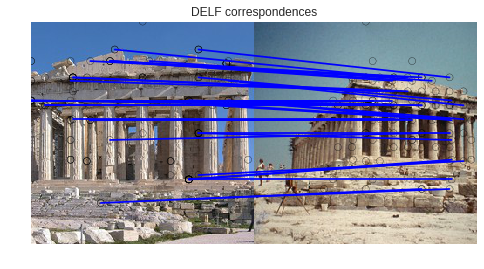

In [7]:
def match_images(results_dict, image_1_path, image_2_path):
  distance_threshold = 0.8

  # Read features.
  locations_1, descriptors_1 = results_dict[image_1_path]
  num_features_1 = locations_1.shape[0]
  print("Loaded image 1's %d features" % num_features_1)
  locations_2, descriptors_2 = results_dict[image_2_path]
  num_features_2 = locations_2.shape[0]
  print("Loaded image 2's %d features" % num_features_2)

  # Find nearest-neighbor matches using a KD tree.
  d1_tree = cKDTree(descriptors_1)
  _, indices = d1_tree.query(
      descriptors_2, distance_upper_bound=distance_threshold)

  # Select feature locations for putative matches.
  locations_2_to_use = np.array([
      locations_2[i,]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])
  locations_1_to_use = np.array([
      locations_1[indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
  ])

  # Perform geometric verification using RANSAC.
  _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)

  print('Found %d inliers' % sum(inliers))

  # Visualize correspondences.
  _, ax = plt.subplots()
  img_1 = mpimg.imread(image_1_path)
  img_2 = mpimg.imread(image_2_path)
  inlier_idxs = np.nonzero(inliers)[0]
  plot_matches(
      ax,
      img_1,
      img_2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
  ax.axis('off')
  ax.set_title('DELF correspondences')

match_images(results_dict, IMAGE_1_JPG, IMAGE_2_JPG)